**Problem 1**

In [ ]:
# get the mlrefined_libraries code from github:
!git clone https://github.com/jermwatt/machine_learning_refined.git
!cd machine_learning_refined
!cp -r machine_learning_refined/mlrefined_libraries mlrefined_libraries
!rm -r machine_learning_refined

Cloning into 'machine_learning_refined'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 2281 (delta 37), reused 1 (delta 1), pack-reused 2200
Receiving objects: 100% (2281/2281), 410.12 MiB | 30.40 MiB/s, done.
Resolving deltas: 100% (787/787), done.
Checking out files: 100% (1577/1577), done.


In [ ]:
# import useful libraries
from autograd import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib
import pandas as pd

optimizers = optlib.optimizers
cost_lib = superlearn.cost_functions

In [ ]:
# load the MNIST dataset:
features, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

# re-shape and 'process' the data:
features = features.T
labels = np.array([int(i) for i in labels])[np.newaxis,:]

In [ ]:
# sample num_samples input/output pairs:
num_samples = 50000
inds = np.random.permutation(labels.shape[1])[:num_samples]

x = features[:, inds]
y = labels[:, inds]

In [ ]:
# does nothing, but makes syntax easy with functional programming
def identity(x):
    normalizer = lambda data: data
    return normalizer

In [ ]:
# function to compute standard normalization of input x:
def standard_normalization(x, eps=0.01):
  # compute the means and standard deviations of the input:
  means = np.mean(x,axis = 1)[:,np.newaxis]
  stds = np.std(x,axis = 1)[:,np.newaxis]

  # replace arbitrarily small elements in the std values with 1, so no division happens:
  stds[stds < eps] = 1

  # return the normalized array:
  normalizer = lambda data: (data - means) / stds
  return normalizer

In [ ]:
# function to compute PCA-sphering of input x:
##### NOTE: This function works on smaller inputs, but I run out of memory when trying to run it here. #####
def PCA_sphering(X):
  means = np.mean(X.T, axis=1)
  centered_matrix = X - means
  covariance = np.cov(centered_matrix.T)
  values, vectors = np.linalg.eig(covariance)
  stds = np.std(vectors,axis = 1)[:,np.newaxis]
  normalize = lambda data: (np.dot(vectors.T, data - means) / stds).T
  return normalize

In [ ]:
# alpha values and other parameters for gradient descent:
alpha_identity = 1e-5
alpha_norm = 1e-1
alpha_PCA = 100
max_its = 10 # number of iterations of gradient descent
costname = 'multiclass_softmax' # name of the cost function
countname = 'multiclass_counter' # name of the counting function

C = len(np.unique(y))
if C == 2: C = 1

In [ ]:
# ---------- GRADIENT DESCENT ---------- #
# different transform functions and their respective alpha values:
transform_functions = [(identity, alpha_identity), (standard_normalization, alpha_norm), (PCA_sphering, alpha_PCA)]

# initialize weights:
w = 0.0 * np.random.randn(x.shape[0]+1, C)

# the gradient descent loop:
cost_histories = []
count_histories = []
for transform, alpha_choice in transform_functions:
  normalizer = transform(x)

  # normalize/transform the input data:
  x_transformed = normalizer(x)

  # create the cost and counter functions:
  cost = cost_lib.choose_cost(x_transformed, y, costname)
  count = cost_lib.choose_cost(x_transformed, y, countname)

  # run iterations of gradient descent:
  weight_history, cost_history = optimizers.gradient_descent(cost, alpha_choice, max_its, w)

  # compute the number of misclassifications:
  count_history = [count(v) for v in weight_history]
  cost_histories.append(cost_history)
  count_histories.append(count_history)

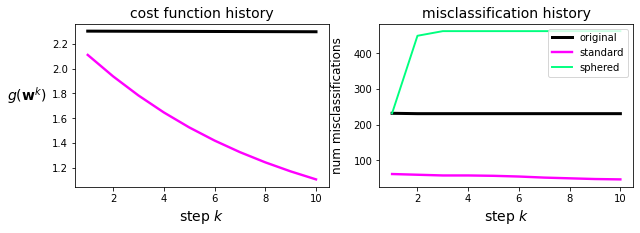

In [ ]:
# compare cost / count histories
static_plotter = superlearn.classification_static_plotter.Visualizer()
static_plotter.plot_histories(cost_histories,count_histories,start = 1,labels = ['original','standard','sphered'])

**NOTE**: The PCA-sphering function could not run (out of space) but it does work. This is why the sphered misclassifications are up - in order to show something for that plot, I replaced the 'sphered' function with the identity function, so that is the data that is being used for 'sphered'.

**Problem 2**

In [ ]:
# import the yale faces database (uploaded to GitHub):
!git clone https://github.com/oriyonay/RandomPublicThings.git
!cp -r RandomPublicThings/yalefaces yalefaces
!rm -rf RandomPublicThings

Cloning into 'RandomPublicThings'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 183 (delta 2), reused 0 (delta 0), pack-reused 161
Receiving objects: 100% (183/183), 6.17 MiB | 29.38 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
# get a list of filenames:
import os
dirname = 'yalefaces'
filenames = sorted(os.listdir(dirname))

# remove 'subject1.gif':
filenames = filenames[1:]

In [ ]:
# import the face images (gif files) as vectors:
faces = []
for filename in filenames:
    # prepend the directory name to the filename:
    filename = dirname + '/' + filename
    
    # read the image:
    face = plt.imread(filename)
    
    # stack rows:
    face = np.hstack(face)
    
    # append face vector to faces:
    faces.append(list(face))

In [ ]:
# 2a) apply PCA on the faces data:
pca = PCA().fit(faces)
faces_transform = pca.transform(faces)

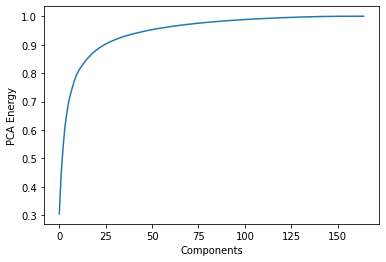

3 components are needed to capture 50% of the energy.


In [ ]:
# 2b)
cumulative_eigenvector_energies = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_eigenvector_energies)
plt.xlabel('Components')
plt.ylabel('PCA Energy')
plt.show()

# how many components do we need for 50% of the energy?
# (note: +1 for human indexing)
num_components = np.argmax(cumulative_eigenvector_energies > 0.5) + 1
print('%d components are needed to capture 50%% of the energy.' % num_components)

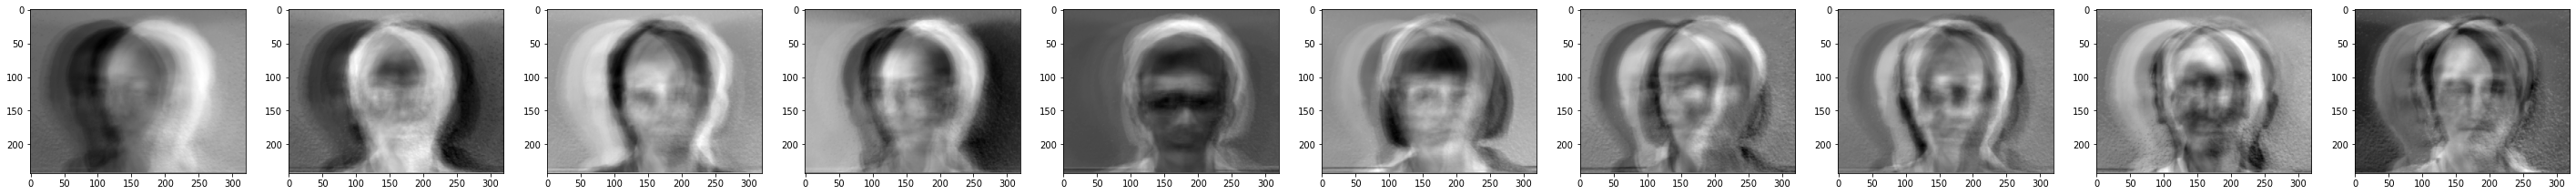

In [ ]:
# 2c) plotting the top 10 eigenfaces:
# (these are the *top* eigenfaces since they're already sorted by explained variance)
eigenfaces = pca.components_.reshape((165, 243, 320))[:10]

fig, ax = plt.subplots(1, 10, figsize=(50, 5))
for i in range(len(eigenfaces)):
  ax[i].imshow(eigenfaces[i], cmap = plt.get_cmap('gray'))

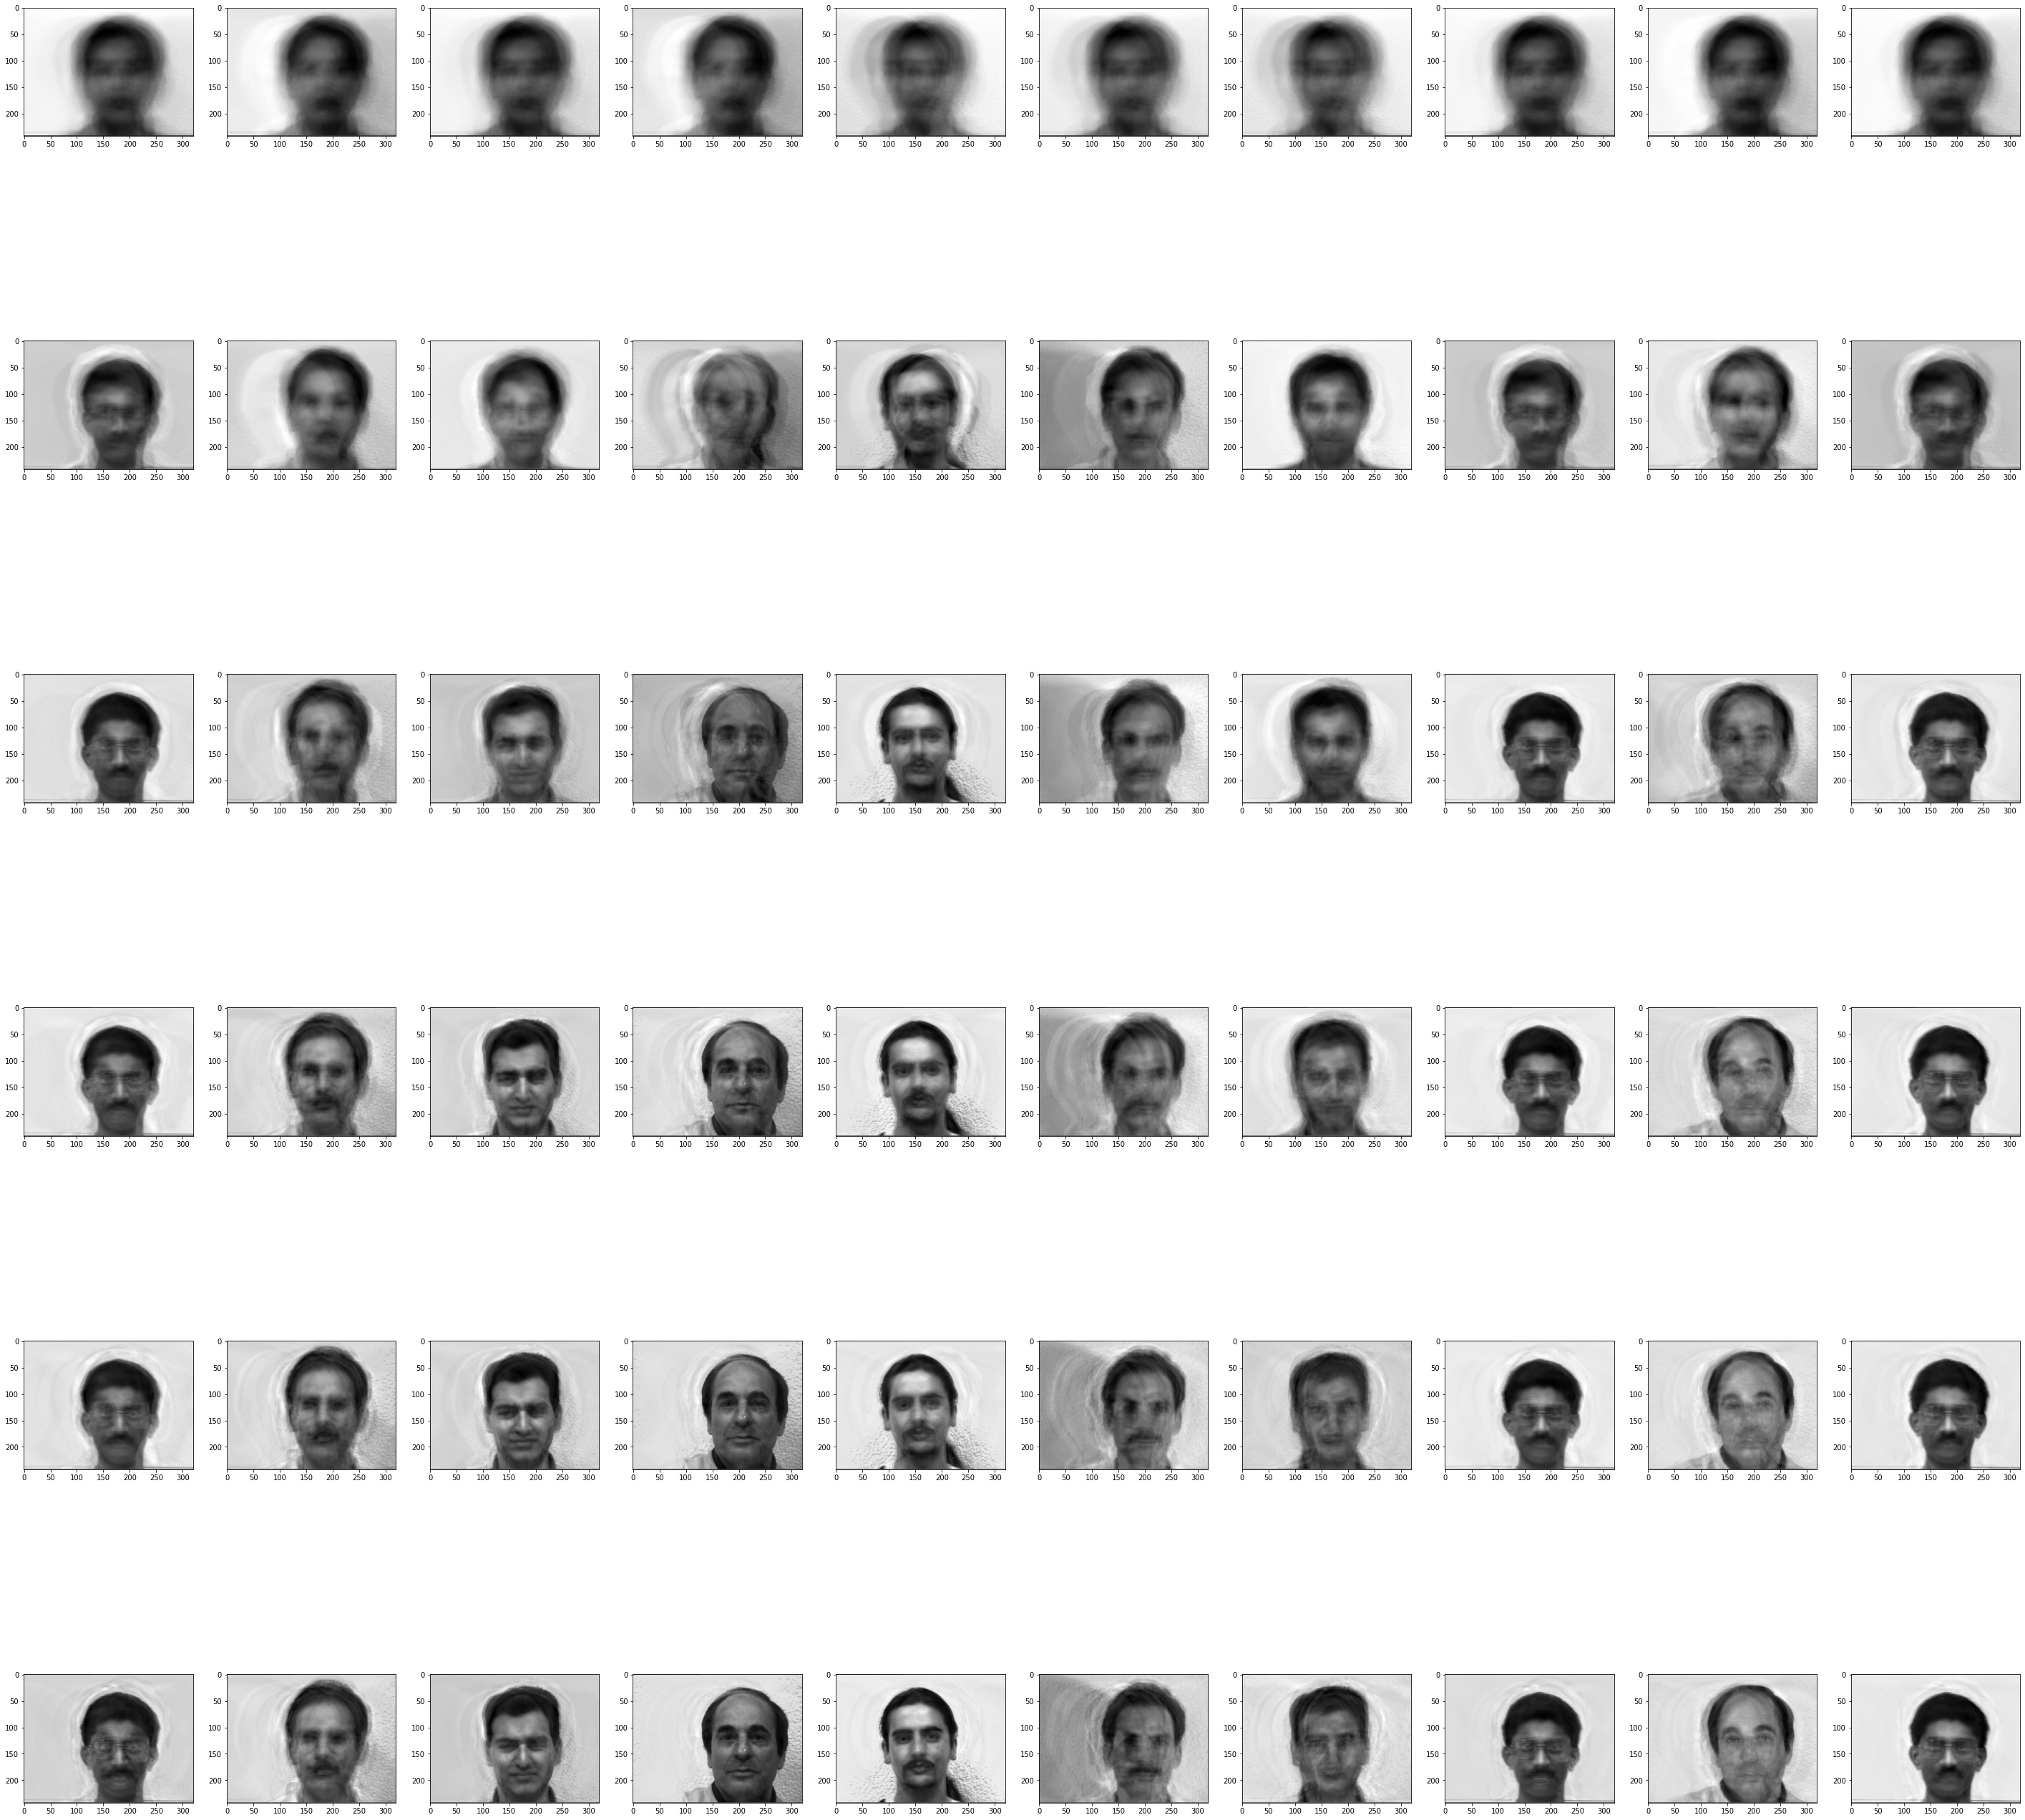

In [ ]:
# 2d)
# selecting random images from the data:
import random
num_images = 10

# pick random indices for images:
rand_indices = [random.randrange(len(faces)) for i in range(num_images)] 

# plot the reconstructed images:
n_components = [1, 10, 20, 30, 40, 50]
fig, ax = plt.subplots(len(n_components), num_images, figsize=(50, 50))

for c in range(len(n_components)):
  pca = PCA(n_components=n_components[c]).fit(faces)
  components = pca.transform(faces)
  projected = pca.inverse_transform(components)
  for i in range(num_images):
    ax[c][i].imshow(np.reshape(projected[rand_indices[i]],[243, 320]), cmap = plt.get_cmap('gray'))

From the above reconstruction, it takes about 20-30 components in order to get a visually good result.

In [ ]:
# 2e) face recognition:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

num_components = [5, 10, 20, 30, 50]

for n_components in num_components:
  print('fitting using %d PCA components...' % n_components)
  # fit PCA:
  pca = PCA(n_components=n_components).fit(faces)
  faces_transform = pca.transform(faces)

  # convert to Pandas DataFrame for easier manipulation:
  X = pd.DataFrame(faces_transform)

  # create the label set:
  y = pd.DataFrame([i//11 for i in range(len(faces))])

  # k-fold cross-validation:
  num_of_folds = 5
  max_iter = 1e8
  f1_dict = {'log_reg': 0,  'svm': 0}

  skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True)
  for train_index, test_index in skf.split(faces_transform, face_labels):
    # split into training and testing data:
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index].values.ravel()
    y_test = y.iloc[test_index].values.ravel()

    # create a support vector machine and fit it to the data:
    svm = SVC(kernel='rbf')
    svm.fit(X_train, y_train)

    # create and fit a logistic regressor with lasso regularization:
    log_regressor = LogisticRegression(penalty='l1', solver='saga', max_iter=max_iter)
    log_regressor.fit(X_train, y_train)

    # make predictions on input:
    log_pred = log_regressor.predict(X_test)
    svm_pred = svm.predict(X_test)

    # add to the average f1 scores:
    log_report = classification_report(digits=6, y_true=y_test, y_pred=log_pred, output_dict=True)
    avg_f1_log = log_report['weighted avg']['f1-score']
    f1_dict['log_reg'] += avg_f1_log / num_of_folds

    svm_report = classification_report(digits=6, y_true=y_test, y_pred=svm_pred, output_dict=True)
    avg_f1_svm = svm_report['weighted avg']['f1-score']
    f1_dict['svm'] += avg_f1_svm / num_of_folds

  # print results for this run:
  print('\tLogistic Regression (with LASSO) f1-score: %.6f' % f1_dict['log_reg'])
  print('\tSVM f1-score: %.6f' % f1_dict['svm'])

fitting using 5 PCA components...
	Logistic Regression (with LASSO) f1-score: 0.582756
	SVM f1-score: 0.604791
fitting using 10 PCA components...
	Logistic Regression (with LASSO) f1-score: 0.831501
	SVM f1-score: 0.710736
fitting using 20 PCA components...
	Logistic Regression (with LASSO) f1-score: 0.875988
	SVM f1-score: 0.786378
fitting using 30 PCA components...
	Logistic Regression (with LASSO) f1-score: 0.872727
	SVM f1-score: 0.819009
fitting using 50 PCA components...
	Logistic Regression (with LASSO) f1-score: 0.892453
	SVM f1-score: 0.803420
